In [1]:
# step 1.a) connecting GCP BigQuery

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

#@title Enter Google Cloud/BigQuery Project ID
project_id = 'impressive-tome-449708-u9' #@param{type:"string"}

# Package used for interfacing w/ BigQuery from Python
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

Authenticated


In [4]:
# step 1.b) Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost shap google-cloud-bigquery pyarrow tqdm plotly

In [5]:
# step 1.c) Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.colab import auth
import datetime
import time
import warnings

# Configure visualization settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

In [6]:
# step 1.d) Create a directory to store extracted data
!mkdir -p data

In [9]:
# step 1.e) Initial check for antibiotic data
print("\nChecking for antibiotic data availability...")

antibiotics_check_query = """
SELECT
  LOWER(drug) AS antibiotic_name,
  COUNT(*) AS prescription_count
FROM
  `physionet-data.mimiciii_clinical.prescriptions`
WHERE
  LOWER(drug) LIKE '%penicillin%' OR
  LOWER(drug) LIKE '%amoxicillin%' OR
  LOWER(drug) LIKE '%ampicillin%' OR
  LOWER(drug) LIKE '%cef%' OR -- cephalosporins
  LOWER(drug) LIKE '%vancomycin%' OR
  LOWER(drug) LIKE '%meropenem%'
GROUP BY
  antibiotic_name
ORDER BY
  prescription_count DESC
LIMIT
  10;
"""

try:
    # Run the query
    abx_check_job = bq_client.query(antibiotics_check_query)
    # Convert to dataframe
    abx_check_df = abx_check_job.to_dataframe()
    # Show results
    print(f"Found {len(abx_check_df)} antibiotic types in the database")
    print(abx_check_df)
except Exception as e:
    print(f"Error running query: {e}")


Checking for antibiotic data availability...
Found 10 antibiotic types in the database
            antibiotic_name  prescription_count
0                vancomycin               42634
1            vancomycin hcl               22291
2                 cefazolin               13260
3                  cefepime                9475
4               ceftriaxone                8602
5                 meropenem                6839
6         ampicillin sodium                2915
7    vancomycin oral liquid                2613
8               ceftazidime                2585
9  neo*iv*ampicillin sodium                2254


In [10]:
# step 1.f) Initial check for microbiology data
print("\nChecking for microbiology culture data...")

culture_check_query = """
SELECT
  org_name,
  COUNT(*) AS culture_count,
  COUNT(DISTINCT subject_id) AS patient_count
FROM
  `physionet-data.mimiciii_clinical.microbiologyevents`
WHERE
  org_name IS NOT NULL
GROUP BY
  org_name
ORDER BY
  culture_count DESC
LIMIT
  10;
"""

try:
    # Run the query
    culture_check_job = bq_client.query(culture_check_query)
    # Convert to dataframe
    culture_check_df = culture_check_job.to_dataframe()
    # Show results
    print(f"Found {len(culture_check_df)} distinct organisms in the microbiology data")
    print(culture_check_df)
except Exception as e:
    print(f"Error running query: {e}")


Checking for microbiology culture data...
Found 10 distinct organisms in the microbiology data
                             org_name  culture_count  patient_count
0                 STAPH AUREUS COAG +          63947           4557
1                    ESCHERICHIA COLI          60133           2870
2  STAPHYLOCOCCUS, COAGULASE NEGATIVE          32777           4461
3               KLEBSIELLA PNEUMONIAE          30628           1453
4              PSEUDOMONAS AERUGINOSA          28926           1523
5                    ENTEROCOCCUS SP.          16429           2676
6                               YEAST          14182           5330
7                   PROTEUS MIRABILIS           9605            581
8                ENTEROBACTER CLOACAE           8709            532
9                 SERRATIA MARCESCENS           6054            339


In [12]:
# step 1.g) Check if antibiotic susceptibilities exist
print("\nChecking for antibiotic susceptibility test results...")

susceptibility_check_query = """
SELECT
  ab_name AS antibiotic_tested,
  interpretation,
  COUNT(*) AS test_count
FROM
  `physionet-data.mimiciii_clinical.microbiologyevents`
WHERE
  ab_name IS NOT NULL
  AND interpretation IS NOT NULL
GROUP BY
  antibiotic_tested, interpretation
ORDER BY
  test_count DESC
LIMIT
  15;
"""

try:
    # Run the query
    susceptibility_job = bq_client.query(susceptibility_check_query)
    # Convert to dataframe
    susceptibility_df = susceptibility_job.to_dataframe()
    # Show results
    print(f"Found {len(susceptibility_df)} antibiotic-interpretation combinations")
    print(susceptibility_df)
except Exception as e:
    print(f"Error running query: {e}")


Checking for antibiotic susceptibility test results...
Found 15 antibiotic-interpretation combinations
     antibiotic_tested interpretation  test_count
0           GENTAMICIN              S       21518
1           TOBRAMYCIN              S       11915
2            MEROPENEM              S       11843
3   TRIMETHOPRIM/SULFA              S       11439
4          CEFTAZIDIME              S       11321
5             CEFEPIME              S       11134
6           VANCOMYCIN              S       10721
7    PIPERACILLIN/TAZO              S       10232
8         LEVOFLOXACIN              R        9722
9          CEFTRIAXONE              S        8821
10        LEVOFLOXACIN              S        8260
11           OXACILLIN              R        7968
12          PENICILLIN              R        7850
13        ERYTHROMYCIN              R        7771
14        TETRACYCLINE              S        7522


In [15]:
# Step 2: Extract Patient Cohort and Infection Data

# Now that we've verified data availability, let's extract our patient cohort
# We want patients who:
# 1. Have an infection diagnosis
# 2. Received antibiotics
# 3. Have microbiology culture results

patients_schema_query = """
SELECT
  column_name
FROM
  `physionet-data.mimiciii_clinical.INFORMATION_SCHEMA.COLUMNS`
WHERE
  table_name = 'patients'
"""

try:
    print("Checking patients table schema...")
    schema_job = bq_client.query(patients_schema_query)
    schema_results = schema_job.result()

    patient_columns = [row.column_name for row in schema_results]
    print(f"Patient table columns: {patient_columns}")
except Exception as e:
    print(f"Error checking schema: {e}")

# Let's also check the admissions table schema
admissions_schema_query = """
SELECT
  column_name
FROM
  `physionet-data.mimiciii_clinical.INFORMATION_SCHEMA.COLUMNS`
WHERE
  table_name = 'admissions'
"""

try:
    print("\nChecking admissions table schema...")
    schema_job = bq_client.query(admissions_schema_query)
    schema_results = schema_job.result()

    admission_columns = [row.column_name for row in schema_results]
    print(f"Admissions table columns: {admission_columns}")
except Exception as e:
    print(f"Error checking schema: {e}")

# Now let's create our patient cohort with the fixed query
print("\nCreating patient cohort with infections who received antibiotics...")

cohort_query = """
-- Create a cohort of patients with suspected bacterial infections
WITH infection_patients AS (
  SELECT DISTINCT
    d.subject_id,
    d.hadm_id
  FROM
    `physionet-data.mimiciii_clinical.diagnoses_icd` d
  JOIN
    `physionet-data.mimiciii_clinical.d_icd_diagnoses` i
    ON d.icd9_code = i.icd9_code
  WHERE
    -- Common infection diagnosis codes
    d.icd9_code LIKE '038%' OR -- Septicemia
    d.icd9_code LIKE '041%' OR -- Bacterial infection in conditions classified elsewhere
    d.icd9_code BETWEEN '480' AND '486' OR -- Pneumonia
    d.icd9_code LIKE '590%' OR -- Kidney infection
    d.icd9_code LIKE '595%' OR -- Cystitis
    d.icd9_code LIKE '599%' OR -- UTI
    d.icd9_code LIKE '682%'     -- Cellulitis and abscess
),

antibiotic_patients AS (
  SELECT DISTINCT
    subject_id,
    hadm_id
  FROM
    `physionet-data.mimiciii_clinical.prescriptions`
  WHERE
    -- Common antibiotics
    LOWER(drug) LIKE '%penicillin%' OR
    LOWER(drug) LIKE '%amoxicillin%' OR
    LOWER(drug) LIKE '%ampicillin%' OR
    LOWER(drug) LIKE '%piperacillin%' OR
    LOWER(drug) LIKE '%ceftriaxone%' OR
    LOWER(drug) LIKE '%cefepime%' OR
    LOWER(drug) LIKE '%vancomycin%' OR
    LOWER(drug) LIKE '%ciprofloxacin%' OR
    LOWER(drug) LIKE '%levofloxacin%' OR
    LOWER(drug) LIKE '%metronidazole%'
),

culture_patients AS (
  SELECT DISTINCT
    subject_id,
    hadm_id
  FROM
    `physionet-data.mimiciii_clinical.microbiologyevents`
  WHERE
    org_name IS NOT NULL
)

-- Combine all criteria to create the final cohort
SELECT
  pat.subject_id,
  adm.hadm_id,
  pat.gender,
  DATETIME_DIFF(adm.admittime, pat.dob, YEAR) AS age,
  adm.admittime,
  adm.dischtime,
  adm.deathtime,
  adm.admission_type,
  adm.admission_location,
  adm.discharge_location,
  adm.insurance,
  adm.ethnicity,
  adm.hospital_expire_flag,
  -- Include flags for our inclusion criteria
  CASE WHEN ip.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_infection_diagnosis,
  CASE WHEN ap.subject_id IS NOT NULL THEN 1 ELSE 0 END AS received_antibiotics,
  CASE WHEN cp.subject_id IS NOT NULL THEN 1 ELSE 0 END AS has_culture_results
FROM
  `physionet-data.mimiciii_clinical.patients` pat
JOIN
  `physionet-data.mimiciii_clinical.admissions` adm
  ON pat.subject_id = adm.subject_id
LEFT JOIN
  infection_patients ip
  ON adm.subject_id = ip.subject_id AND adm.hadm_id = ip.hadm_id
LEFT JOIN
  antibiotic_patients ap
  ON adm.subject_id = ap.subject_id AND adm.hadm_id = ap.hadm_id
LEFT JOIN
  culture_patients cp
  ON adm.subject_id = cp.subject_id AND adm.hadm_id = cp.hadm_id
WHERE
  -- Require at least antibiotics AND (infection diagnosis OR culture)
  ap.subject_id IS NOT NULL
  AND (ip.subject_id IS NOT NULL OR cp.subject_id IS NOT NULL)
ORDER BY
  pat.subject_id, adm.admittime
LIMIT 10000;
"""

try:
    # Run the query
    print("Extracting patient cohort data - this may take a few minutes...")
    start_time = time.time()
    cohort_job = bq_client.query(cohort_query)
    # Convert to dataframe
    cohort_df = cohort_job.to_dataframe()
    elapsed_time = time.time() - start_time
    print(f"Query executed in {elapsed_time:.2f} seconds")

    # Save to CSV
    cohort_df.to_csv('data/patient_cohort.csv', index=False)

    # Display basic stats
    print(f"Extracted cohort with {len(cohort_df)} patient admissions")
    print(f"Number of unique patients: {cohort_df['subject_id'].nunique()}")
    print(f"Patients with infection diagnosis: {cohort_df['has_infection_diagnosis'].sum()}")
    print(f"Patients who received antibiotics: {cohort_df['received_antibiotics'].sum()}")
    print(f"Patients with culture results: {cohort_df['has_culture_results'].sum()}")

    # Show demographic statistics
    print("\nDemographics:")
    print(f"Gender distribution: \n{cohort_df['gender'].value_counts()}")
    print(f"Age statistics: \n{cohort_df['age'].describe()}")
    print(f"Mortality rate: {cohort_df['hospital_expire_flag'].mean():.2%}")

    # Show a sample of the data
    print("\nSample patient data:")
    display_cols = ['subject_id', 'hadm_id', 'gender', 'age', 'admission_type',
                    'has_infection_diagnosis', 'received_antibiotics', 'has_culture_results']
    print(cohort_df[display_cols].head())
except Exception as e:
    print(f"Error extracting cohort: {e}")

# Now extract infection-related diagnoses with fixed query
print("\nExtracting infection-related diagnoses...")

diagnoses_query = """
SELECT
  d.subject_id,
  d.hadm_id,
  d.seq_num,
  d.icd9_code,
  i.short_title,
  i.long_title,
  -- Flag certain infection types
  CASE
    WHEN d.icd9_code LIKE '038%' THEN 'Septicemia'
    WHEN d.icd9_code LIKE '041%' THEN 'Bacterial Infection'
    WHEN d.icd9_code BETWEEN '480' AND '486' THEN 'Pneumonia'
    WHEN d.icd9_code LIKE '590%' THEN 'Kidney Infection'
    WHEN d.icd9_code LIKE '595%' THEN 'Cystitis'
    WHEN d.icd9_code LIKE '599%' THEN 'Urinary Tract Infection'
    WHEN d.icd9_code LIKE '601%' THEN 'Prostatitis'
    WHEN d.icd9_code BETWEEN '680' AND '686' THEN 'Skin Infection'
    WHEN d.icd9_code LIKE '730%' THEN 'Osteomyelitis'
    ELSE 'Other Infection'
  END AS infection_type,
  -- Flag if primary diagnosis (seq_num=1)
  CASE WHEN d.seq_num = 1 THEN 1 ELSE 0 END AS is_primary
FROM
  `physionet-data.mimiciii_clinical.diagnoses_icd` d
JOIN
  `physionet-data.mimiciii_clinical.d_icd_diagnoses` i
  ON d.icd9_code = i.icd9_code
WHERE
  d.subject_id IN (
    SELECT DISTINCT subject_id
    FROM `physionet-data.mimiciii_clinical.prescriptions`
    WHERE LOWER(drug) LIKE '%vancomycin%' OR LOWER(drug) LIKE '%ceftriaxone%'
  )
  AND (
    d.icd9_code LIKE '038%' OR -- Septicemia
    d.icd9_code LIKE '041%' OR -- Bacterial infection
    d.icd9_code BETWEEN '480' AND '486' OR -- Pneumonia
    d.icd9_code LIKE '590%' OR -- Kidney infection
    d.icd9_code LIKE '595%' OR -- Cystitis
    d.icd9_code LIKE '599%' OR -- UTI
    d.icd9_code LIKE '601%' OR -- Prostatitis
    d.icd9_code BETWEEN '680' AND '686' OR -- Skin infections
    d.icd9_code LIKE '730%' -- Osteomyelitis
  )
ORDER BY
  d.subject_id, d.hadm_id, d.seq_num
LIMIT 10000;
"""

try:
    # Run the query
    print("Extracting infection diagnoses - this may take a few minutes...")
    start_time = time.time()
    diagnoses_job = bq_client.query(diagnoses_query)
    # Convert to dataframe
    diagnoses_df = diagnoses_job.to_dataframe()
    elapsed_time = time.time() - start_time
    print(f"Query executed in {elapsed_time:.2f} seconds")

    # Save to CSV
    diagnoses_df.to_csv('data/infection_diagnoses.csv', index=False)

    # Display basic stats
    print(f"Extracted {len(diagnoses_df)} infection-related diagnosis records")
    print(f"Number of unique patients: {diagnoses_df['subject_id'].nunique()}")
    print(f"Number of unique hospitalizations: {diagnoses_df[['subject_id', 'hadm_id']].drop_duplicates().shape[0]}")

    # Show infection type distribution
    print("\nInfection type distribution:")
    infection_counts = diagnoses_df['infection_type'].value_counts()
    print(infection_counts)

    # Count primary infection diagnoses
    primary_infections = diagnoses_df[diagnoses_df['is_primary'] == 1]
    print(f"\nNumber of hospitalizations with infection as primary diagnosis: {len(primary_infections)}")

    # Show a sample of the data
    print("\nSample infection diagnosis data:")
    display_cols = ['subject_id', 'hadm_id', 'seq_num', 'icd9_code', 'short_title', 'infection_type', 'is_primary']
    print(diagnoses_df[display_cols].head())
except Exception as e:
    print(f"Error extracting infection diagnoses: {e}")

Checking patients table schema...
Patient table columns: ['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG']

Checking admissions table schema...
Admissions table columns: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']

Creating patient cohort with infections who received antibiotics...
Extracting patient cohort data - this may take a few minutes...
Query executed in 3.37 seconds
Extracted cohort with 10000 patient admissions
Number of unique patients: 7659
Patients with infection diagnosis: 7397
Patients who received antibiotics: 10000
Patients with culture results: 8219

Demographics:
Gender distribution: 
gender
M    5290
F    4710
Name: count, dtype: int64
Age statistics: 
count      10000.0
mean       77.6

Using existing cohort data

Extracting antibiotic prescriptions for the cohort...
Extracting antibiotic prescription data - this may take a few minutes...
Query executed in 3.28 seconds
Extracted 10510 antibiotic prescription records
Number of unique patients: 1000
Number of unique hospitalizations: 1478

Antibiotic class distribution:
antibiotic_class
Glycopeptides                  3322
Fluoroquinolones               2144
Nitroimidazoles                1127
Antipseudomonal Penicillins     833
3rd Gen Cephalosporins          636
Aminoglycosides                 385
Macrolides                      358
Carbapenems                     331
Penicillins                     329
1st Gen Cephalosporins          307
4th Gen Cephalosporins          231
Oxazolidinones                  198
Lincosamides                    171
Monobactams                      75
Lipopeptides                     57
Sulfonamides                      6
Name: count, dtype: int64

Antibiotic spectrum distribution:
spectrum

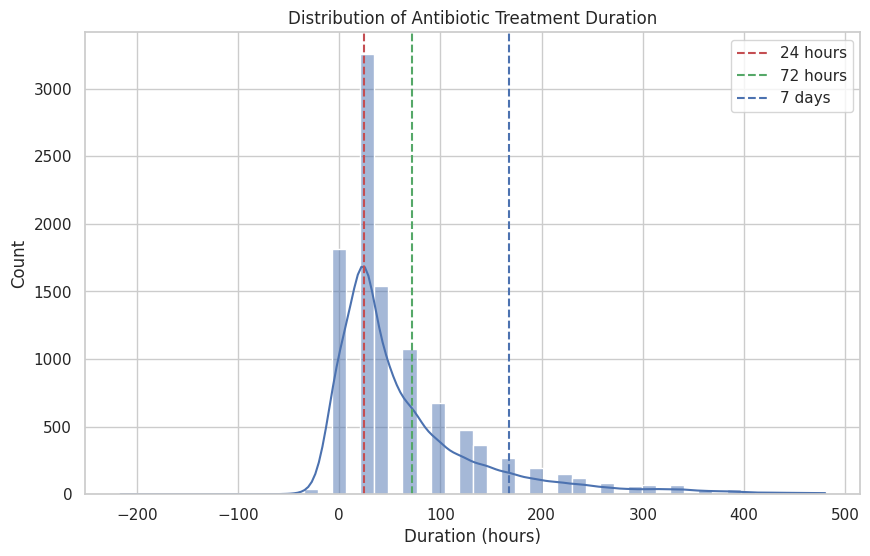

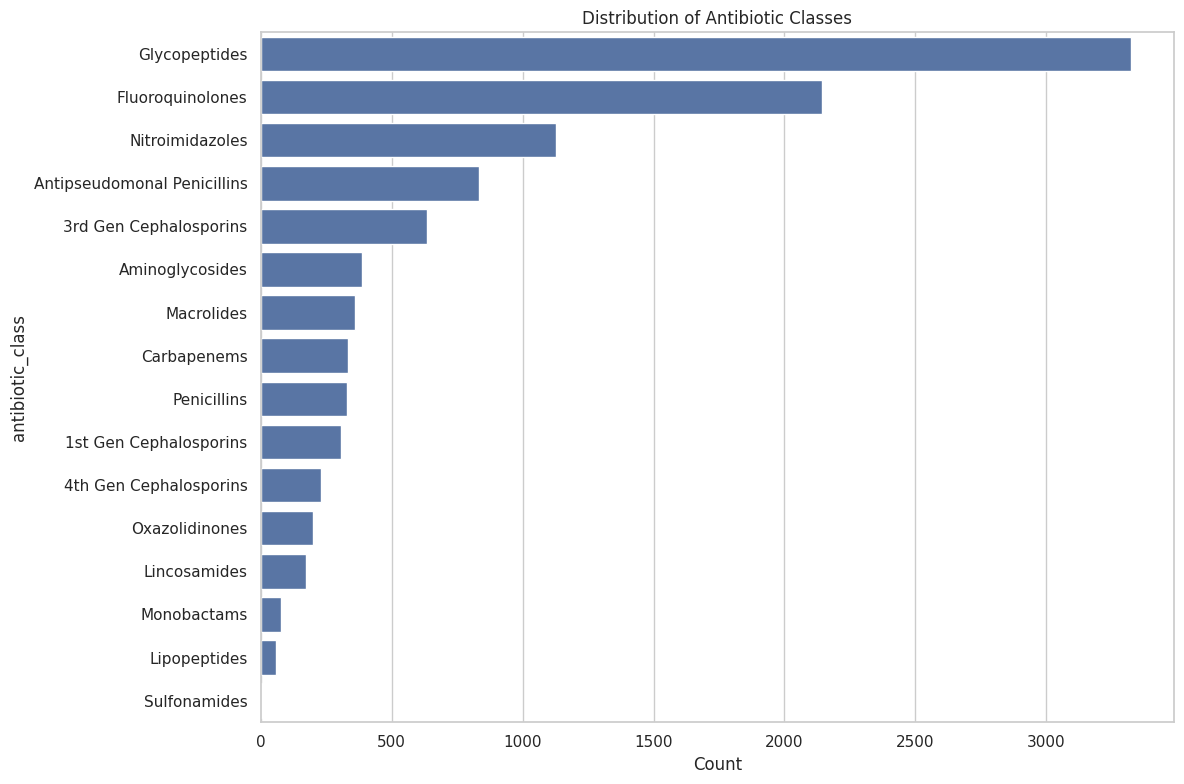

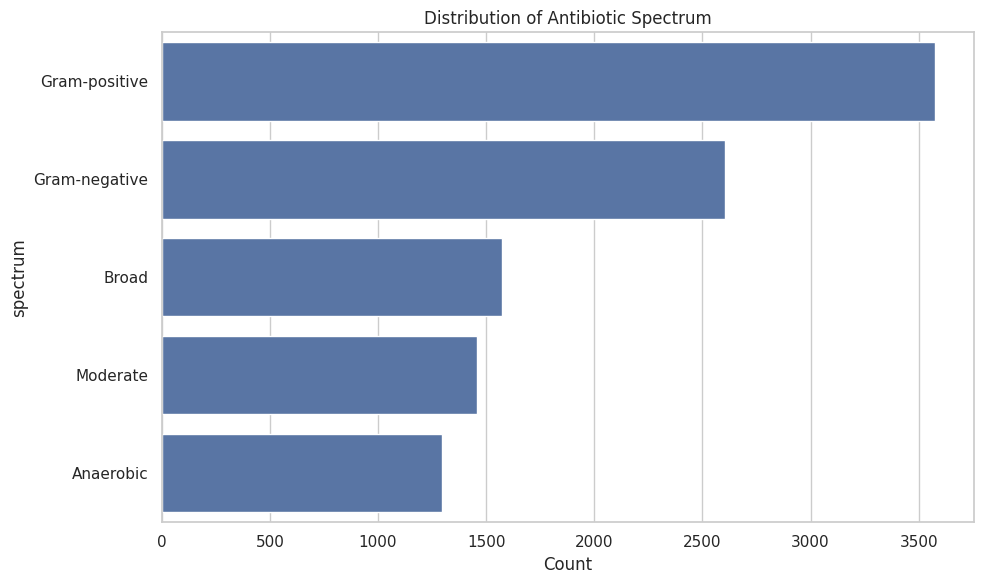


Analyzing empiric antibiotic therapy...
Number of hospitalizations with empiric therapy data: 1478

Distribution of empiric antibiotic therapy by class:
antibiotic_class
Fluoroquinolones               419
Glycopeptides                  363
1st Gen Cephalosporins         131
3rd Gen Cephalosporins         126
Nitroimidazoles                113
Antipseudomonal Penicillins     69
Penicillins                     61
Macrolides                      46
Aminoglycosides                 41
Lincosamides                    34
4th Gen Cephalosporins          32
Carbapenems                     20
Oxazolidinones                  16
Monobactams                      4
Lipopeptides                     3
Name: count, dtype: int64

Analyzing antibiotic combinations...

Most common antibiotic combinations in first 24 hours:
combination
Fluoroquinolones                                      246
Glycopeptides                                         165
1st Gen Cephalosporins                                11

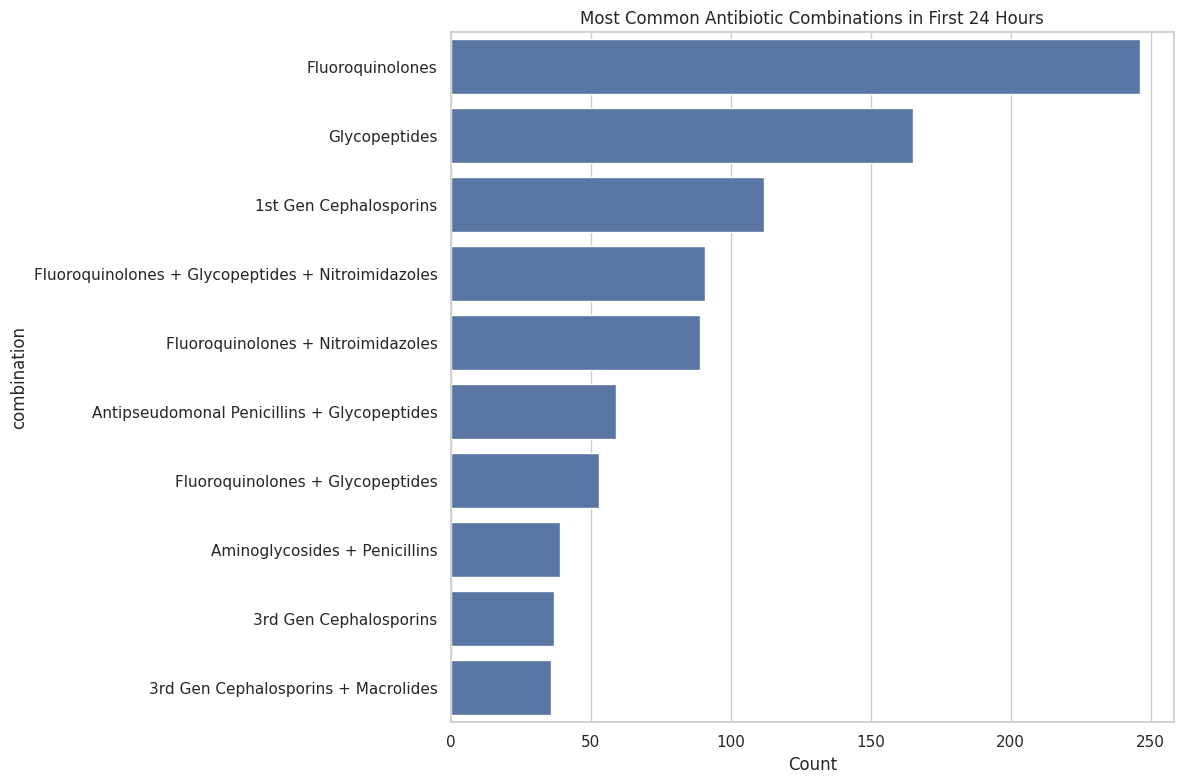

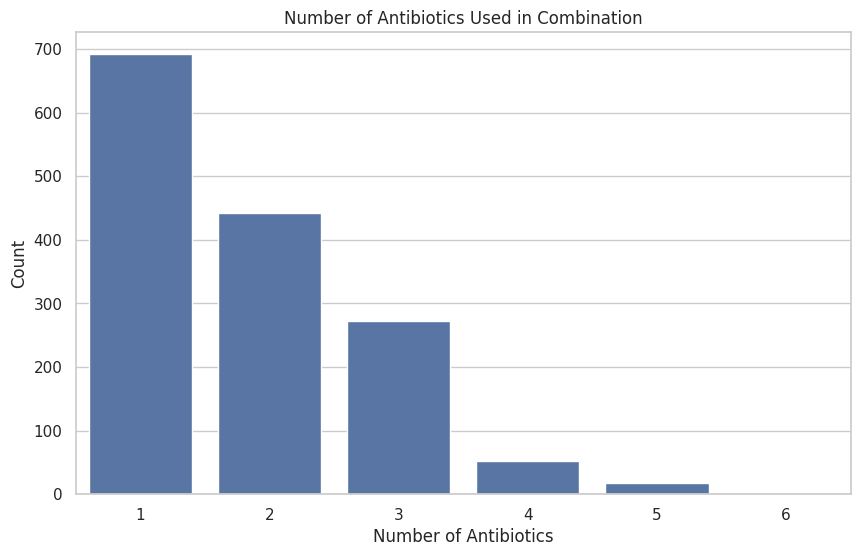


Analyzing relationship between infection type and antibiotic selection...
Using existing diagnoses data
Merged data has 230 records with both infection type and first antibiotic


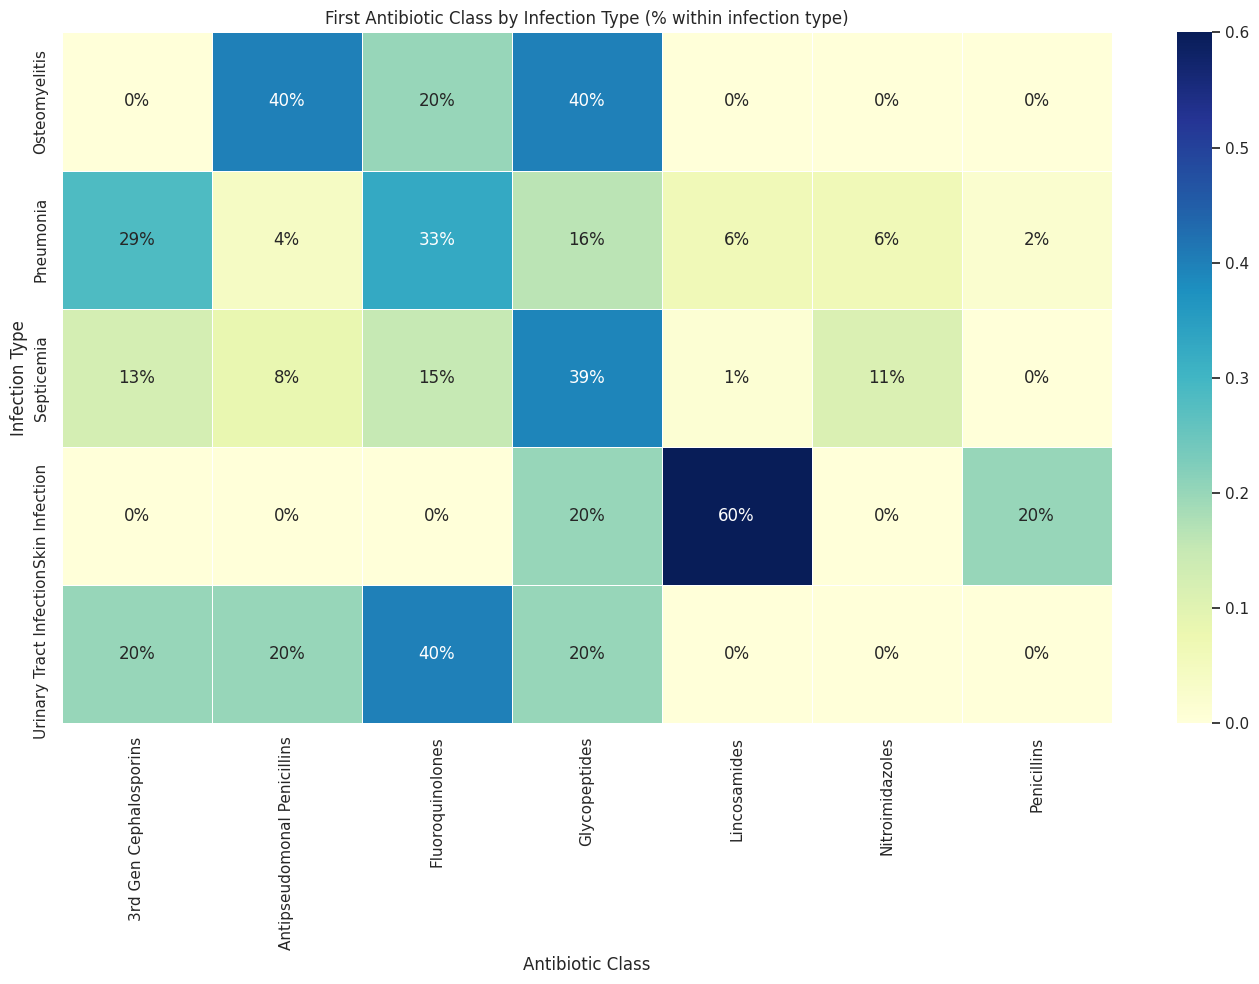


Antibiotic data processing complete. Files saved to the data directory.


In [16]:
# Antibiotic Stewardship: Predicting Appropriate Antibiotic Selection
# Step 3: Extract Antibiotic Prescriptions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go

# Load patient cohort data if not already in memory
try:
    cohort_df
    print("Using existing cohort data")
except NameError:
    print("Loading cohort data from CSV")
    cohort_df = pd.read_csv('data/patient_cohort.csv')
    print(f"Loaded cohort with {len(cohort_df)} patient admissions")

# Step 1: Extract antibiotic prescriptions for our cohort
print("\nExtracting antibiotic prescriptions for the cohort...")

# Create a string list of subject_ids for our query
# Limit to 1000 patients for the demo to avoid query size limits
subject_ids = cohort_df['subject_id'].unique()[:1000]
subject_ids_str = ', '.join([str(id) for id in subject_ids])

antibiotics_query = f"""
SELECT
  p.subject_id,
  p.hadm_id,
  p.icustay_id,
  p.startdate,
  p.enddate,
  DATETIME_DIFF(p.enddate, p.startdate, HOUR) AS duration_hours,
  p.drug,
  p.drug_name_poe,
  p.drug_name_generic,
  p.formulary_drug_cd,
  p.prod_strength,
  p.dose_val_rx,
  p.dose_unit_rx,
  p.form_val_disp,
  p.form_unit_disp,
  p.route,
  -- Classify antibiotics by class
  CASE
    WHEN LOWER(p.drug) LIKE '%penicillin%' OR
         LOWER(p.drug) LIKE '%amoxicillin%' OR
         LOWER(p.drug) LIKE '%ampicillin%' OR
         LOWER(p.drug) LIKE '%nafcillin%' OR
         LOWER(p.drug) LIKE '%oxacillin%' OR
         LOWER(p.drug) LIKE '%dicloxacillin%' THEN 'Penicillins'
    WHEN LOWER(p.drug) LIKE '%piperacillin%' OR
         LOWER(p.drug) LIKE '%ticarcillin%' THEN 'Antipseudomonal Penicillins'
    WHEN LOWER(p.drug) LIKE '%cefazolin%' OR
         LOWER(p.drug) LIKE '%cephalexin%' THEN '1st Gen Cephalosporins'
    WHEN LOWER(p.drug) LIKE '%cefoxitin%' OR
         LOWER(p.drug) LIKE '%cefuroxime%' OR
         LOWER(p.drug) LIKE '%cefotetan%' THEN '2nd Gen Cephalosporins'
    WHEN LOWER(p.drug) LIKE '%cefotaxime%' OR
         LOWER(p.drug) LIKE '%ceftriaxone%' OR
         LOWER(p.drug) LIKE '%ceftazidime%' THEN '3rd Gen Cephalosporins'
    WHEN LOWER(p.drug) LIKE '%cefepime%' THEN '4th Gen Cephalosporins'
    WHEN LOWER(p.drug) LIKE '%aztreonam%' THEN 'Monobactams'
    WHEN LOWER(p.drug) LIKE '%imipenem%' OR
         LOWER(p.drug) LIKE '%meropenem%' OR
         LOWER(p.drug) LIKE '%ertapenem%' OR
         LOWER(p.drug) LIKE '%doripenem%' THEN 'Carbapenems'
    WHEN LOWER(p.drug) LIKE '%erythromycin%' OR
         LOWER(p.drug) LIKE '%azithromycin%' OR
         LOWER(p.drug) LIKE '%clarithromycin%' THEN 'Macrolides'
    WHEN LOWER(p.drug) LIKE '%gentamicin%' OR
         LOWER(p.drug) LIKE '%tobramycin%' OR
         LOWER(p.drug) LIKE '%amikacin%' THEN 'Aminoglycosides'
    WHEN LOWER(p.drug) LIKE '%ciprofloxacin%' OR
         LOWER(p.drug) LIKE '%levofloxacin%' OR
         LOWER(p.drug) LIKE '%moxifloxacin%' OR
         LOWER(p.drug) LIKE '%gemifloxacin%' THEN 'Fluoroquinolones'
    WHEN LOWER(p.drug) LIKE '%vancomycin%' THEN 'Glycopeptides'
    WHEN LOWER(p.drug) LIKE '%clindamycin%' THEN 'Lincosamides'
    WHEN LOWER(p.drug) LIKE '%linezolid%' THEN 'Oxazolidinones'
    WHEN LOWER(p.drug) LIKE '%daptomycin%' THEN 'Lipopeptides'
    WHEN LOWER(p.drug) LIKE '%metronidazole%' THEN 'Nitroimidazoles'
    WHEN LOWER(p.drug) LIKE '%trimethoprim%sulfamethoxazole%' OR
         LOWER(p.drug) LIKE '%tmp%smx%' OR
         LOWER(p.drug) LIKE '%bactrim%' THEN 'Sulfonamides'
    WHEN LOWER(p.drug) LIKE '%tetracycline%' OR
         LOWER(p.drug) LIKE '%doxycycline%' OR
         LOWER(p.drug) LIKE '%minocycline%' THEN 'Tetracyclines'
    WHEN LOWER(p.drug) LIKE '%polymyxin%' OR
         LOWER(p.drug) LIKE '%colistin%' THEN 'Polymyxins'
    ELSE 'Other'
  END AS antibiotic_class,
  -- Classify by spectrum (simplified)
  CASE
    WHEN LOWER(p.drug) LIKE '%piperacillin%tazobactam%' OR
         LOWER(p.drug) LIKE '%ticarcillin%clavulanate%' OR
         LOWER(p.drug) LIKE '%imipenem%' OR
         LOWER(p.drug) LIKE '%meropenem%' OR
         LOWER(p.drug) LIKE '%cefepime%' OR
         LOWER(p.drug) LIKE '%ceftazidime%' THEN 'Broad'
    WHEN LOWER(p.drug) LIKE '%vancomycin%' OR
         LOWER(p.drug) LIKE '%linezolid%' OR
         LOWER(p.drug) LIKE '%daptomycin%' THEN 'Gram-positive'
    WHEN LOWER(p.drug) LIKE '%gentamicin%' OR
         LOWER(p.drug) LIKE '%tobramycin%' OR
         LOWER(p.drug) LIKE '%amikacin%' OR
         LOWER(p.drug) LIKE '%ciprofloxacin%' OR
         LOWER(p.drug) LIKE '%levofloxacin%' OR
         LOWER(p.drug) LIKE '%aztreonam%' THEN 'Gram-negative'
    WHEN LOWER(p.drug) LIKE '%metronidazole%' OR
         LOWER(p.drug) LIKE '%clindamycin%' THEN 'Anaerobic'
    ELSE 'Moderate'
  END AS spectrum
FROM
  `physionet-data.mimiciii_clinical.prescriptions` p
WHERE
  p.subject_id IN ({subject_ids_str})
  AND (
  LOWER(p.drug) LIKE '%penicillin%' OR
  LOWER(p.drug) LIKE '%amoxicillin%' OR
  LOWER(p.drug) LIKE '%ampicillin%' OR
  LOWER(p.drug) LIKE '%piperacillin%' OR
  LOWER(p.drug) LIKE '%ticarcillin%' OR
  LOWER(p.drug) LIKE '%cefazolin%' OR
  LOWER(p.drug) LIKE '%cefoxitin%' OR
  LOWER(p.drug) LIKE '%cefotaxime%' OR
  LOWER(p.drug) LIKE '%ceftriaxone%' OR
  LOWER(p.drug) LIKE '%ceftazidime%' OR
  LOWER(p.drug) LIKE '%cefepime%' OR
  LOWER(p.drug) LIKE '%aztreonam%' OR
  LOWER(p.drug) LIKE '%imipenem%' OR
  LOWER(p.drug) LIKE '%meropenem%' OR
  LOWER(p.drug) LIKE '%ertapenem%' OR
  LOWER(p.drug) LIKE '%azithromycin%' OR
  LOWER(p.drug) LIKE '%clarithromycin%' OR
  LOWER(p.drug) LIKE '%erythromycin%' OR
  LOWER(p.drug) LIKE '%gentamicin%' OR
  LOWER(p.drug) LIKE '%tobramycin%' OR
  LOWER(p.drug) LIKE '%amikacin%' OR
  LOWER(p.drug) LIKE '%ciprofloxacin%' OR
  LOWER(p.drug) LIKE '%levofloxacin%' OR
  LOWER(p.drug) LIKE '%moxifloxacin%' OR
  LOWER(p.drug) LIKE '%vancomycin%' OR
  LOWER(p.drug) LIKE '%linezolid%' OR
  LOWER(p.drug) LIKE '%daptomycin%' OR
  LOWER(p.drug) LIKE '%clindamycin%' OR
  LOWER(p.drug) LIKE '%metronidazole%' OR
  LOWER(p.drug) LIKE '%trimethoprim%sulfamethoxazole%' OR
  LOWER(p.drug) LIKE '%tmp%smx%' OR
  LOWER(p.drug) LIKE '%bactrim%'
  )
ORDER BY
  p.subject_id, p.hadm_id, p.startdate;
"""

try:
    # Run the query
    print("Extracting antibiotic prescription data - this may take a few minutes...")
    start_time = time.time()
    antibiotics_job = bq_client.query(antibiotics_query)
    # Convert to dataframe
    antibiotics_df = antibiotics_job.to_dataframe()
    elapsed_time = time.time() - start_time
    print(f"Query executed in {elapsed_time:.2f} seconds")

    # Save to CSV
    antibiotics_df.to_csv('data/antibiotics.csv', index=False)

    # Display basic stats
    print(f"Extracted {len(antibiotics_df)} antibiotic prescription records")
    print(f"Number of unique patients: {antibiotics_df['subject_id'].nunique()}")
    print(f"Number of unique hospitalizations: {antibiotics_df[['subject_id', 'hadm_id']].drop_duplicates().shape[0]}")

    # Show antibiotic class distribution
    print("\nAntibiotic class distribution:")
    class_counts = antibiotics_df['antibiotic_class'].value_counts()
    print(class_counts)

    # Show antibiotic spectrum distribution
    print("\nAntibiotic spectrum distribution:")
    spectrum_counts = antibiotics_df['spectrum'].value_counts()
    print(spectrum_counts)

    # Show a sample of the data
    print("\nSample antibiotic data:")
    display_cols = ['subject_id', 'hadm_id', 'drug', 'startdate', 'enddate', 'duration_hours', 'antibiotic_class', 'spectrum']
    print(antibiotics_df[display_cols].head())

    # Analyze antibiotic duration
    plt.figure(figsize=(10, 6))
    # Filter out extreme outliers
    duration_data = antibiotics_df[antibiotics_df['duration_hours'] < 500]
    sns.histplot(duration_data['duration_hours'], bins=50, kde=True)
    plt.title('Distribution of Antibiotic Treatment Duration')
    plt.xlabel('Duration (hours)')
    plt.ylabel('Count')
    plt.axvline(x=24, color='r', linestyle='--', label='24 hours')
    plt.axvline(x=72, color='g', linestyle='--', label='72 hours')
    plt.axvline(x=168, color='b', linestyle='--', label='7 days')
    plt.legend()
    plt.savefig('data/antibiotic_duration.png')
    plt.show()

    # Visualize antibiotic class distribution
    plt.figure(figsize=(12, 8))
    sns.barplot(x=class_counts.values, y=class_counts.index)
    plt.title('Distribution of Antibiotic Classes')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('data/antibiotic_classes.png')
    plt.show()

    # Visualize antibiotic spectrum distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=spectrum_counts.values, y=spectrum_counts.index)
    plt.title('Distribution of Antibiotic Spectrum')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('data/antibiotic_spectrum.png')
    plt.show()

    # Step 2: Identify first antibiotic for each admission (empiric therapy)
    print("\nAnalyzing empiric antibiotic therapy...")

    # Convert startdate to datetime
    antibiotics_df['startdate'] = pd.to_datetime(antibiotics_df['startdate'])

    # Group by admission and find first antibiotic(s)
    first_abx = antibiotics_df.sort_values(['subject_id', 'hadm_id', 'startdate'])
    first_abx = first_abx.groupby(['subject_id', 'hadm_id']).first().reset_index()

    print(f"Number of hospitalizations with empiric therapy data: {len(first_abx)}")

    # Show distribution of first antibiotic by class
    print("\nDistribution of empiric antibiotic therapy by class:")
    first_abx_class = first_abx['antibiotic_class'].value_counts()
    print(first_abx_class)

    # Step 3: Analyze antibiotic combinations (within first 24 hours)
    print("\nAnalyzing antibiotic combinations...")

    # Define a function to get antibiotics administered within first 24 hours
    def get_early_antibiotics(subject_id, hadm_id, antibiotics_df):
        # Get all antibiotics for this admission
        adm_abx = antibiotics_df[(antibiotics_df['subject_id'] == subject_id) &
                                (antibiotics_df['hadm_id'] == hadm_id)]
        if len(adm_abx) == 0:
            return []

        # Find earliest antibiotic time
        earliest_time = adm_abx['startdate'].min()

        # Get antibiotics within 24 hours of the earliest
        cutoff_time = earliest_time + pd.Timedelta(hours=24)
        early_abx = adm_abx[adm_abx['startdate'] < cutoff_time]

        # Return unique antibiotic classes
        return list(early_abx['antibiotic_class'].unique())

    # Apply the function to each admission
    combination_data = []
    unique_admissions = antibiotics_df[['subject_id', 'hadm_id']].drop_duplicates().values

    for subject_id, hadm_id in unique_admissions:
        early_abx = get_early_antibiotics(subject_id, hadm_id, antibiotics_df)
        # Sort to ensure consistent combination naming
        early_abx.sort()
        combination = " + ".join(early_abx)
        combination_data.append({
            'subject_id': subject_id,
            'hadm_id': hadm_id,
            'antibiotics': early_abx,
            'combination': combination,
            'count': len(early_abx)
        })

    combinations_df = pd.DataFrame(combination_data)

    # Count frequency of different combinations
    print("\nMost common antibiotic combinations in first 24 hours:")
    combo_counts = combinations_df['combination'].value_counts().head(10)
    print(combo_counts)

    # Count number of antibiotics used in combination
    print("\nNumber of antibiotics used in combinations:")
    count_distribution = combinations_df['count'].value_counts().sort_index()
    print(count_distribution)

    # Visualize common combinations
    plt.figure(figsize=(12, 8))
    sns.barplot(x=combo_counts.values, y=combo_counts.index)
    plt.title('Most Common Antibiotic Combinations in First 24 Hours')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.savefig('data/antibiotic_combinations.png')
    plt.show()

    # Visualize number of antibiotics in combination
    plt.figure(figsize=(10, 6))
    sns.barplot(x=count_distribution.index, y=count_distribution.values)
    plt.title('Number of Antibiotics Used in Combination')
    plt.xlabel('Number of Antibiotics')
    plt.ylabel('Count')
    plt.savefig('data/antibiotic_count_distribution.png')
    plt.show()

    # Step 4: Analyze relationship between infection type and antibiotic selection
    print("\nAnalyzing relationship between infection type and antibiotic selection...")

    # Load infection diagnoses if not already in memory
    try:
        diagnoses_df
        print("Using existing diagnoses data")
    except NameError:
        print("Loading diagnoses data from CSV")
        diagnoses_df = pd.read_csv('data/infection_diagnoses.csv')
        print(f"Loaded {len(diagnoses_df)} infection diagnosis records")

    # Get primary infection for each admission
    primary_infections = diagnoses_df[diagnoses_df['is_primary'] == 1][['subject_id', 'hadm_id', 'infection_type']]

    # If multiple primary infections, use the first one listed
    primary_infections = primary_infections.groupby(['subject_id', 'hadm_id']).first().reset_index()

    # Merge with first antibiotic data
    infection_abx = pd.merge(
        primary_infections,
        first_abx[['subject_id', 'hadm_id', 'antibiotic_class', 'spectrum']],
        on=['subject_id', 'hadm_id'],
        how='inner'
    )

    print(f"Merged data has {len(infection_abx)} records with both infection type and first antibiotic")

    # Create a crosstab to analyze relationship
    infection_abx_table = pd.crosstab(
        infection_abx['infection_type'],
        infection_abx['antibiotic_class'],
        normalize='index'
    )

    # Filter to include only classes that are at least 5% for some infection
    significant_classes = []
    for col in infection_abx_table.columns:
        if (infection_abx_table[col] >= 0.05).any():
            significant_classes.append(col)

    # Create a heatmap of the most significant patterns
    plt.figure(figsize=(14, 10))
    sns.heatmap(
        infection_abx_table[significant_classes],
        cmap='YlGnBu',
        annot=True,
        fmt='.0%',
        linewidths=0.5
    )
    plt.title('First Antibiotic Class by Infection Type (% within infection type)')
    plt.ylabel('Infection Type')
    plt.xlabel('Antibiotic Class')
    plt.tight_layout()
    plt.savefig('data/infection_antibiotic_heatmap.png')
    plt.show()

    # Save processed data for future use
    antibiotics_df.to_csv('data/processed_antibiotics.csv', index=False)
    first_abx.to_csv('data/first_antibiotics.csv', index=False)
    combinations_df.to_csv('data/antibiotic_combinations.csv', index=False)
    infection_abx.to_csv('data/infection_antibiotic_mapping.csv', index=False)

    print("\nAntibiotic data processing complete. Files saved to the data directory.")

except Exception as e:
    print(f"Error processing antibiotic data: {e}")

In [18]:
# Antibiotic Stewardship: Predicting Appropriate Antibiotic Selection
# Step 4: Extract Microbiology Culture and Susceptibility Data (Fixed)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime, timedelta

# Load patient cohort and antibiotics data if not already in memory
try:
    cohort_df
    print("Using existing cohort data")
except NameError:
    print("Loading cohort data from CSV")
    cohort_df = pd.read_csv('data/patient_cohort.csv')
    print(f"Loaded cohort with {len(cohort_df)} patient admissions")

try:
    antibiotics_df
    print("Using existing antibiotics data")
except NameError:
    print("Loading antibiotics data from CSV")
    antibiotics_df = pd.read_csv('data/processed_antibiotics.csv')
    print(f"Loaded {len(antibiotics_df)} antibiotic prescription records")

# Step 1: Extract microbiology culture results
print("\nExtracting microbiology culture results...")

# Create a string list of subject_ids for our query
# We'll use the same patients as in the antibiotics analysis
subject_ids = cohort_df['subject_id'].unique()[:1000]
subject_ids_str = ', '.join([str(id) for id in subject_ids])

cultures_query = f"""
SELECT
  m.subject_id,
  m.hadm_id,
  m.chartdate,
  m.charttime,
  m.spec_itemid,
  m.spec_type_desc,
  m.org_itemid,
  m.org_name,
  m.isolate_num,
  m.ab_itemid,
  m.ab_name,
  m.dilution_text,
  m.dilution_comparison,
  m.dilution_value,
  m.interpretation
FROM
  `physionet-data.mimiciii_clinical.microbiologyevents` m
WHERE
  m.subject_id IN ({subject_ids_str})
  AND m.org_name IS NOT NULL
ORDER BY
  m.subject_id, m.hadm_id, m.chartdate, m.org_itemid, m.ab_itemid;
"""

try:
    # Run the query
    print("Extracting microbiology culture data - this may take a few minutes...")
    start_time = time.time()
    cultures_job = bq_client.query(cultures_query)
    # Convert to dataframe
    cultures_df = cultures_job.to_dataframe()
    elapsed_time = time.time() - start_time
    print(f"Query executed in {elapsed_time:.2f} seconds")

    # Save to CSV
    cultures_df.to_csv('data/cultures.csv', index=False)

    # Display basic stats
    print(f"Extracted {len(cultures_df)} microbiology culture records")
    print(f"Number of unique patients: {cultures_df['subject_id'].nunique()}")
    print(f"Number of unique hospitalizations: {cultures_df[['subject_id', 'hadm_id']].drop_duplicates().shape[0]}")

    # Show organism distribution
    print("\nTop 10 organisms identified in cultures:")
    org_counts = cultures_df['org_name'].value_counts().head(10)
    print(org_counts)

    # Show specimen types
    print("\nTop 10 specimen types:")
    spec_counts = cultures_df['spec_type_desc'].value_counts().head(10)
    print(spec_counts)

    # Show interpretation distribution (S/I/R)
    print("\nAntibiotic susceptibility interpretation distribution:")
    if 'interpretation' in cultures_df.columns:
        interp_counts = cultures_df['interpretation'].value_counts()
        print(interp_counts)
    else:
        print("No interpretation data available")

    # Show a sample of the data
    print("\nSample culture data:")
    display_cols = ['subject_id', 'hadm_id', 'chartdate', 'spec_type_desc', 'org_name', 'ab_name', 'interpretation']
    print(cultures_df[display_cols].head())

    # Step 2: Visualize organism distribution
    plt.figure(figsize=(12, 8))
    if len(org_counts) > 0:
        sns.barplot(x=org_counts.values, y=org_counts.index)
        plt.title('Most Common Organisms Identified in Cultures')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig('data/common_organisms.png')
        plt.close()
    else:
        print("No organism data available for plotting")

    # Step 3: Analyze specimen types
    plt.figure(figsize=(12, 8))
    if len(spec_counts) > 0:
        sns.barplot(x=spec_counts.values, y=spec_counts.index)
        plt.title('Distribution of Specimen Types')
        plt.xlabel('Count')
        plt.tight_layout()
        plt.savefig('data/specimen_types.png')
        plt.close()
    else:
        print("No specimen type data available for plotting")

    # Step 4: Analyze susceptibility patterns for common organisms
    print("\nAnalyzing antibiotic susceptibility patterns...")

    # Check if we have susceptibility data
    if 'interpretation' not in cultures_df.columns or cultures_df['interpretation'].isna().all():
        print("No susceptibility data available for analysis")
    else:
        # Get most common organisms (top 5)
        top_organisms = cultures_df['org_name'].value_counts().head(5).index.tolist()

        # Check if we have antibiotic names
        if 'ab_name' not in cultures_df.columns or cultures_df['ab_name'].isna().all():
            print("No antibiotic name data available for analysis")
        else:
            # Get commonly tested antibiotics (at least 100 tests)
            antibiotics_with_counts = cultures_df['ab_name'].value_counts()
            common_antibiotics = antibiotics_with_counts[antibiotics_with_counts > 50].index.tolist()

            if len(common_antibiotics) == 0:
                print("Not enough antibiotic susceptibility data for analysis")
            else:
                # Create susceptibility heatmap data
                susceptibility_data = []

                for org in top_organisms:
                    for abx in common_antibiotics:
                        # Get susceptibility data for this organism-antibiotic pair
                        subset = cultures_df[(cultures_df['org_name'] == org) &
                                          (cultures_df['ab_name'] == abx) &
                                          (cultures_df['interpretation'].notna())]

                        if len(subset) > 0:
                            # Calculate percentages
                            s_count = sum(subset['interpretation'] == 'S')
                            i_count = sum(subset['interpretation'] == 'I')
                            r_count = sum(subset['interpretation'] == 'R')
                            total = s_count + i_count + r_count

                            if total > 0:
                                s_percent = s_count / total * 100
                                i_percent = i_count / total * 100
                                r_percent = r_count / total * 100

                                susceptibility_data.append({
                                    'organism': org,
                                    'antibiotic': abx,
                                    'susceptible_percent': s_percent,
                                    'intermediate_percent': i_percent,
                                    'resistant_percent': r_percent,
                                    'count': total
                                })

                susceptibility_df = pd.DataFrame(susceptibility_data)

                # Create a heatmap of susceptibility percentages if we have data
                if len(susceptibility_df) > 0:
                    # Pivot the data for the heatmap
                    pivot_df = susceptibility_df.pivot(index='organism', columns='antibiotic', values='susceptible_percent')

                    # Replace NaN values with a placeholder (e.g., -1) for visualization
                    pivot_df_filled = pivot_df.fillna(-1)

                    # Create a mask for NaN values
                    mask = pivot_df.isna()

                    plt.figure(figsize=(16, 10))
                    sns.heatmap(pivot_df_filled, annot=True, cmap='YlGnBu', fmt='.1f',
                               linewidths=0.5, vmin=0, vmax=100, mask=mask)
                    plt.title('Antibiotic Susceptibility Patterns (% Susceptible)')
                    plt.ylabel('Organism')
                    plt.xlabel('Antibiotic')
                    plt.tight_layout()
                    plt.savefig('data/susceptibility_heatmap.png')
                    plt.close()
                else:
                    print("Insufficient data for susceptibility heatmap")

    # Step 5: Link cultures to antibiotic prescriptions to evaluate appropriateness
    print("\nLinking culture results to antibiotic prescriptions...")

    # Convert date columns to datetime
    if 'chartdate' in cultures_df.columns:
        cultures_df['chartdate'] = pd.to_datetime(cultures_df['chartdate'])

    if 'startdate' in antibiotics_df.columns:
        antibiotics_df['startdate'] = pd.to_datetime(antibiotics_df['startdate'])

    # Check if we have the necessary data for appropriateness analysis
    if ('chartdate' not in cultures_df.columns or
        'startdate' not in antibiotics_df.columns or
        'interpretation' not in cultures_df.columns or
        'antibiotic_class' not in antibiotics_df.columns):
        print("Missing necessary columns for appropriateness analysis")
    else:
        # Function to determine if an antibiotic is appropriate for an organism based on susceptibility
        def is_appropriate(organism, antibiotic_class, cultures_df):
            """
            Determines if an antibiotic class is appropriate for an organism based on susceptibility data
            """
            # Map antibiotic classes to specific antibiotics tested in the lab
            class_to_ab_map = {
                'Penicillins': ['PENICILLIN', 'AMPICILLIN', 'OXACILLIN', 'NAFCILLIN'],
                'Antipseudomonal Penicillins': ['PIPERACILLIN/TAZO'],
                '1st Gen Cephalosporins': ['CEFAZOLIN'],
                '3rd Gen Cephalosporins': ['CEFTRIAXONE', 'CEFTAZIDIME'],
                '4th Gen Cephalosporins': ['CEFEPIME'],
                'Carbapenems': ['MEROPENEM', 'IMIPENEM'],
                'Fluoroquinolones': ['LEVOFLOXACIN', 'CIPROFLOXACIN'],
                'Aminoglycosides': ['GENTAMICIN', 'TOBRAMYCIN'],
                'Glycopeptides': ['VANCOMYCIN'],
                'Macrolides': ['ERYTHROMYCIN'],
                'Lincosamides': ['CLINDAMYCIN'],
                'Oxazolidinones': ['LINEZOLID'],
                'Lipopeptides': ['DAPTOMYCIN'],
                'Nitroimidazoles': [], # Metronidazole not typically tested in standard panels
                'Sulfonamides': ['TRIMETHOPRIM/SULFA']
            }

            # Get antibiotics to check for this class
            antibiotics_to_check = class_to_ab_map.get(antibiotic_class, [])

            if not antibiotics_to_check:
                # If no mapping available, we can't determine
                return None

            # Find susceptibility results for this organism and any of these antibiotics
            org_results = cultures_df[cultures_df['org_name'] == organism]

            if len(org_results) == 0:
                return None

            matched_results = org_results[org_results['ab_name'].isin(antibiotics_to_check)]

            if len(matched_results) == 0:
                return None

            # Check if at least one antibiotic in the class is susceptible
            has_susceptible = (matched_results['interpretation'] == 'S').any()

            return has_susceptible

        # Create a dataframe to store matching results
        matching_results = []

        # Get unique combinations of patients and admissions with cultures
        culture_admits = cultures_df[['subject_id', 'hadm_id']].drop_duplicates().values

        for subject_id, hadm_id in culture_admits:
            # Get culture data for this admission
            adm_cultures = cultures_df[(cultures_df['subject_id'] == subject_id) &
                                     (cultures_df['hadm_id'] == hadm_id)]

            # Get earliest culture collection date
            if len(adm_cultures) > 0 and not adm_cultures['chartdate'].isna().all():
                earliest_culture = adm_cultures['chartdate'].min()

                # Get organisms identified in cultures
                organisms = adm_cultures['org_name'].unique()

                # Get antibiotics prescribed within 2 days before the culture collection
                timeframe_start = earliest_culture - pd.Timedelta(days=2)
                timeframe_end = earliest_culture

                empiric_abx = antibiotics_df[(antibiotics_df['subject_id'] == subject_id) &
                                          (antibiotics_df['hadm_id'] == hadm_id) &
                                          (antibiotics_df['startdate'] >= timeframe_start) &
                                          (antibiotics_df['startdate'] <= timeframe_end)]

                if len(empiric_abx) > 0:
                    # Get antibiotic classes prescribed
                    abx_classes = empiric_abx['antibiotic_class'].unique()

                    # Check appropriateness for each organism-antibiotic class pair
                    for organism in organisms:
                        for abx_class in abx_classes:
                            appropriate = is_appropriate(organism, abx_class, adm_cultures)

                            matching_results.append({
                                'subject_id': subject_id,
                                'hadm_id': hadm_id,
                                'organism': organism,
                                'antibiotic_class': abx_class,
                                'appropriate': appropriate,
                                'culture_date': earliest_culture,
                                'specimen_types': ', '.join(adm_cultures['spec_type_desc'].unique())
                            })

        # Convert to dataframe
        if len(matching_results) > 0:
            matching_df = pd.DataFrame(matching_results)

            # Save results
            matching_df.to_csv('data/antibiotic_appropriateness.csv', index=False)

            # Calculate appropriateness rates
            print("\nAnalyzing antibiotic appropriateness...")

            # Remove rows where appropriateness couldn't be determined
            valid_matches = matching_df[matching_df['appropriate'].notna()]

            if len(valid_matches) > 0:
                # Overall appropriateness
                overall_appropriate = valid_matches['appropriate'].mean() * 100
                print(f"Overall antibiotic appropriateness rate: {overall_appropriate:.1f}%")

                # Appropriateness by organism
                print("\nAppropriateness by organism:")
                org_appropriate = valid_matches.groupby('organism')['appropriate'].agg(['mean', 'count'])
                org_appropriate['mean'] = org_appropriate['mean'] * 100
                print(org_appropriate.sort_values('count', ascending=False).head(10))

                # Appropriateness by antibiotic class
                print("\nAppropriateness by antibiotic class:")
                abx_appropriate = valid_matches.groupby('antibiotic_class')['appropriate'].agg(['mean', 'count'])
                abx_appropriate['mean'] = abx_appropriate['mean'] * 100
                print(abx_appropriate.sort_values('count', ascending=False))

                # Visualize appropriateness by organism
                top_orgs = org_appropriate.sort_values('count', ascending=False).head(10)

                plt.figure(figsize=(12, 8))
                sns.barplot(x=top_orgs['mean'].values, y=top_orgs.index)
                plt.title('Antibiotic Appropriateness by Organism')
                plt.xlabel('Appropriateness Rate (%)')
                plt.axvline(x=overall_appropriate, color='r', linestyle='--', label=f'Overall ({overall_appropriate:.1f}%)')
                plt.legend()
                plt.tight_layout()
                plt.savefig('data/appropriateness_by_organism.png')
                plt.close()

                # Visualize appropriateness by antibiotic class
                plt.figure(figsize=(12, 8))
                sns.barplot(x=abx_appropriate['mean'].values, y=abx_appropriate.index)
                plt.title('Antibiotic Appropriateness by Class')
                plt.xlabel('Appropriateness Rate (%)')
                plt.axvline(x=overall_appropriate, color='r', linestyle='--', label=f'Overall ({overall_appropriate:.1f}%)')
                plt.legend()
                plt.tight_layout()
                plt.savefig('data/appropriateness_by_class.png')
                plt.close()

                # Create a heatmap of appropriateness by organism-antibiotic pairs
                # First, ensure there are no NaN values
                try:
                    # Pivot the data for the heatmap
                    heatmap_data = valid_matches.groupby(['organism', 'antibiotic_class'])['appropriate'].mean() * 100
                    heatmap_pivot = heatmap_data.unstack()

                    # Filter to include only organisms and antibiotics with sufficient data
                    org_counts = valid_matches['organism'].value_counts()
                    abx_counts = valid_matches['antibiotic_class'].value_counts()

                    common_orgs = org_counts[org_counts >= 10].index
                    common_abx = abx_counts[abx_counts >= 10].index

                    if len(common_orgs) > 0 and len(common_abx) > 0:
                        # Filter the pivot table
                        filtered_pivot = heatmap_pivot.loc[common_orgs, common_abx]

                        # Handle NaN values
                        filtered_pivot_filled = filtered_pivot.fillna(-1)
                        mask = filtered_pivot.isna()

                        plt.figure(figsize=(16, 10))
                        sns.heatmap(filtered_pivot_filled, annot=True, cmap='RdYlGn', fmt='.1f',
                                   linewidths=0.5, vmin=0, vmax=100, mask=mask)
                        plt.title('Antibiotic Appropriateness by Organism-Antibiotic Pair (% Appropriate)')
                        plt.ylabel('Organism')
                        plt.xlabel('Antibiotic Class')
                        plt.tight_layout()
                        plt.savefig('data/appropriateness_heatmap.png')
                        plt.close()
                    else:
                        print("Insufficient data for appropriateness heatmap")
                except Exception as heatmap_error:
                    print(f"Error creating appropriateness heatmap: {heatmap_error}")
            else:
                print("Insufficient data to calculate appropriateness rates")
        else:
            print("No matching results found for appropriateness analysis")

    print("\nMicrobiology data processing complete. Files saved to the data directory.")

except Exception as e:
    print(f"Error processing microbiology data: {e}")
    import traceback
    traceback.print_exc()

Using existing cohort data
Using existing antibiotics data

Extracting microbiology culture results...
Extracting microbiology culture data - this may take a few minutes...
Query executed in 1.93 seconds
Extracted 19139 microbiology culture records
Number of unique patients: 810
Number of unique hospitalizations: 1090

Top 10 organisms identified in cultures:
org_name
STAPH AUREUS COAG +                   4404
ESCHERICHIA COLI                      2829
STAPHYLOCOCCUS, COAGULASE NEGATIVE    2307
KLEBSIELLA PNEUMONIAE                 1735
PSEUDOMONAS AERUGINOSA                1337
ENTEROCOCCUS SP.                      1020
YEAST                                  853
ENTEROBACTER CLOACAE                   558
SERRATIA MARCESCENS                    416
PROTEUS MIRABILIS                      311
Name: count, dtype: int64

Top 10 specimen types:
spec_type_desc
SPUTUM                    5428
URINE                     4501
BLOOD CULTURE             3635
SWAB                      2164
CATHETER T

Loading culture data...
Loaded 19139 culture records
Found 15841 records with susceptibility results
Top organisms: ['STAPH AUREUS COAG +', 'ESCHERICHIA COLI', 'STAPHYLOCOCCUS, COAGULASE NEGATIVE', 'KLEBSIELLA PNEUMONIAE', 'PSEUDOMONAS AERUGINOSA', 'ENTEROCOCCUS SP.']
Common antibiotics: ['GENTAMICIN', 'LEVOFLOXACIN', 'PENICILLIN', 'OXACILLIN', 'VANCOMYCIN', 'ERYTHROMYCIN', 'CEFTAZIDIME', 'TOBRAMYCIN', 'CEFEPIME', 'MEROPENEM', 'PIPERACILLIN/TAZO', 'TETRACYCLINE', 'CEFTRIAXONE', 'TRIMETHOPRIM/SULFA', 'CLINDAMYCIN', 'CIPROFLOXACIN', 'AMPICILLIN', 'PIPERACILLIN', 'RIFAMPIN', 'IMIPENEM', 'AMPICILLIN/SULBACTAM', 'CEFAZOLIN', 'CEFUROXIME', 'NITROFURANTOIN']
Calculating susceptibility rates...
Created summary with 76 organism-antibiotic combinations
Saved susceptibility summary to data/susceptibility_summary.csv
Creating susceptibility heatmap...
Susceptibility rates (% susceptible):
antibiotic                          AMPICILLIN  AMPICILLIN/SULBACTAM  \
organism                              

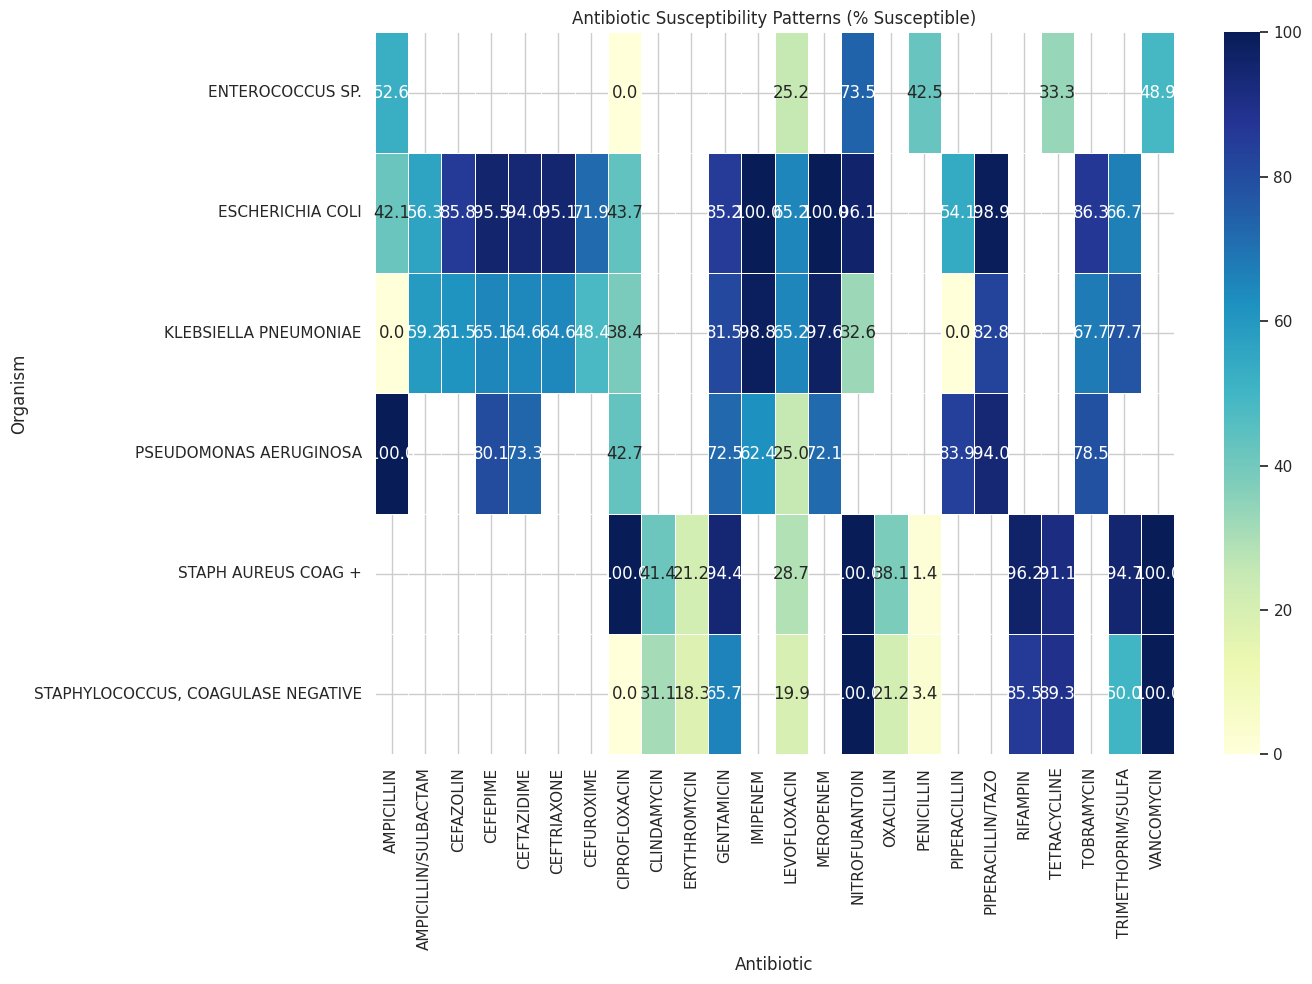

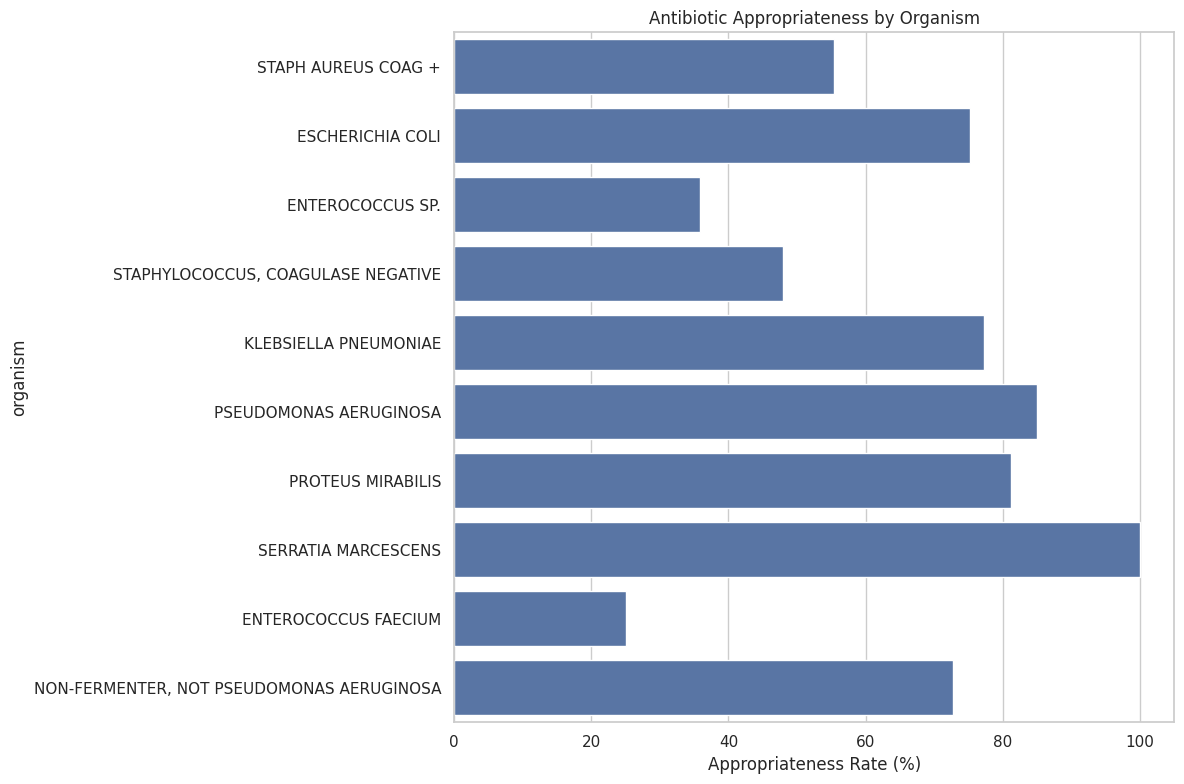

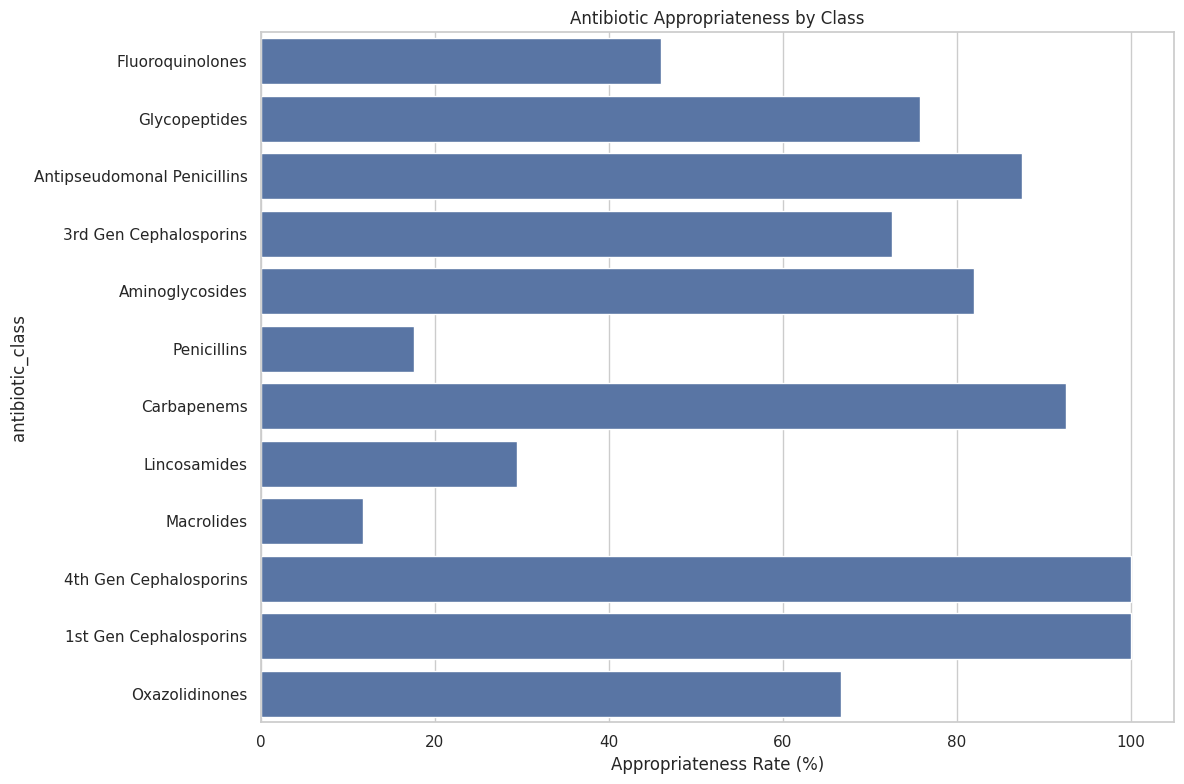

In [19]:
# Create  the susceptibility heatmap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the microbiology culture data
print("Loading culture data...")
cultures_df = pd.read_csv('data/cultures.csv')
print(f"Loaded {len(cultures_df)} culture records")

# Filter to include only records with susceptibility results
susceptibility_df = cultures_df[cultures_df['interpretation'].notna()]
print(f"Found {len(susceptibility_df)} records with susceptibility results")

# Get most common organisms and antibiotics
top_organisms = cultures_df['org_name'].value_counts().head(6).index.tolist()
print(f"Top organisms: {top_organisms}")

# Get commonly tested antibiotics
antibiotics_with_counts = susceptibility_df['ab_name'].value_counts()
common_antibiotics = antibiotics_with_counts[antibiotics_with_counts > 100].index.tolist()
print(f"Common antibiotics: {common_antibiotics}")

# If we have too few common antibiotics, lower the threshold
if len(common_antibiotics) < 5:
    common_antibiotics = antibiotics_with_counts[antibiotics_with_counts > 50].index.tolist()
    print(f"Adjusted common antibiotics (>50 tests): {common_antibiotics}")

# Create susceptibility summary data
print("Calculating susceptibility rates...")
susceptibility_data = []

for org in top_organisms:
    for abx in common_antibiotics:
        # Get susceptibility data for this organism-antibiotic pair
        subset = susceptibility_df[(susceptibility_df['org_name'] == org) &
                              (susceptibility_df['ab_name'] == abx)]

        if len(subset) > 0:
            # Calculate percentages
            s_count = sum(subset['interpretation'] == 'S')
            total = len(subset)

            if total > 0:
                s_percent = s_count / total * 100

                susceptibility_data.append({
                    'organism': org,
                    'antibiotic': abx,
                    'susceptible_percent': s_percent,
                    'count': total
                })

susceptibility_summary = pd.DataFrame(susceptibility_data)
print(f"Created summary with {len(susceptibility_summary)} organism-antibiotic combinations")

# Save the summary data
susceptibility_summary.to_csv('data/susceptibility_summary.csv', index=False)
print("Saved susceptibility summary to data/susceptibility_summary.csv")

# Create heatmap data by pivoting
if len(susceptibility_summary) > 0:
    print("Creating susceptibility heatmap...")

    # Pivot the data
    pivot_df = susceptibility_summary.pivot(index='organism', columns='antibiotic', values='susceptible_percent')

    # Print the pivot table
    print("Susceptibility rates (% susceptible):")
    print(pivot_df)

    # Create heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=0.5, vmin=0, vmax=100)
    plt.title('Antibiotic Susceptibility Patterns (% Susceptible)')
    plt.ylabel('Organism')
    plt.xlabel('Antibiotic')
    plt.tight_layout()
    plt.savefig('data/susceptibility_heatmap.png')
    print("Saved susceptibility heatmap to data/susceptibility_heatmap.png")
else:
    print("Insufficient data for susceptibility heatmap")

# Create appropriateness analysis
print("\nAnalyzing appropriateness data...")
try:
    # Load appropriateness data
    appropriateness_df = pd.read_csv('data/antibiotic_appropriateness.csv')
    print(f"Loaded {len(appropriateness_df)} appropriateness records")

    # Remove rows where appropriateness couldn't be determined
    valid_matches = appropriateness_df[appropriateness_df['appropriate'].notna()]
    print(f"Found {len(valid_matches)} records with valid appropriateness determination")

    if len(valid_matches) > 0:
        # Calculate appropriateness by organism
        org_appropriate = valid_matches.groupby('organism')['appropriate'].agg(['mean', 'count'])
        org_appropriate['mean'] = org_appropriate['mean'] * 100
        org_appropriate = org_appropriate.sort_values('count', ascending=False)

        # Calculate appropriateness by antibiotic class
        abx_appropriate = valid_matches.groupby('antibiotic_class')['appropriate'].agg(['mean', 'count'])
        abx_appropriate['mean'] = abx_appropriate['mean'] * 100
        abx_appropriate = abx_appropriate.sort_values('count', ascending=False)

        # Print the data
        print("\nAppropriateness by organism:")
        print(org_appropriate.head(10))

        print("\nAppropriateness by antibiotic class:")
        print(abx_appropriate)

        # Create visualization for organism appropriateness
        plt.figure(figsize=(12, 8))
        top_orgs = org_appropriate.head(10)
        sns.barplot(x=top_orgs['mean'].values, y=top_orgs.index)
        plt.title('Antibiotic Appropriateness by Organism')
        plt.xlabel('Appropriateness Rate (%)')
        plt.tight_layout()
        plt.savefig('data/appropriateness_by_organism.png')
        print("Saved organism appropriateness chart to data/appropriateness_by_organism.png")

        # Create visualization for antibiotic class appropriateness
        plt.figure(figsize=(12, 8))
        sns.barplot(x=abx_appropriate['mean'].values, y=abx_appropriate.index)
        plt.title('Antibiotic Appropriateness by Class')
        plt.xlabel('Appropriateness Rate (%)')
        plt.tight_layout()
        plt.savefig('data/appropriateness_by_class.png')
        print("Saved antibiotic class appropriateness chart to data/appropriateness_by_class.png")
    else:
        print("Insufficient data for appropriateness analysis")
except Exception as e:
    print(f"Error analyzing appropriateness data: {e}")

print("Visualization script completed")

In [20]:
# Antibiotic Stewardship: Predicting Appropriate Antibiotic Selection
# Step 5: Develop Machine Learning Models for Antibiotic Selection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import xgboost as XGBClassifier

print("Loading previously processed data...")

# Load patient cohort data
cohort_df = pd.read_csv('data/patient_cohort.csv')
print(f"Loaded patient cohort with {len(cohort_df)} records")

# Load antibiotic data
antibiotics_df = pd.read_csv('data/processed_antibiotics.csv')
print(f"Loaded antibiotic data with {len(antibiotics_df)} records")

# Load culture data
cultures_df = pd.read_csv('data/cultures.csv')
print(f"Loaded culture data with {len(cultures_df)} records")

# Load susceptibility summary
susceptibility_df = pd.read_csv('data/susceptibility_summary.csv')
print(f"Loaded susceptibility data with {len(susceptibility_df)} records")

# Load appropriateness data
appropriateness_df = pd.read_csv('data/antibiotic_appropriateness.csv')
print(f"Loaded appropriateness data with {len(appropriateness_df)} records")

# Filter to include only records with valid appropriateness determination
valid_appropriateness = appropriateness_df[appropriateness_df['appropriate'].notna()].copy()
print(f"Found {len(valid_appropriateness)} records with valid appropriateness determination")

# Step 1: Data Preparation
print("\nPreparing data for machine learning...")

# Convert date columns to datetime
valid_appropriateness['culture_date'] = pd.to_datetime(valid_appropriateness['culture_date'])

# Merge with patient demographics
merged_data = pd.merge(
    valid_appropriateness,
    cohort_df[['subject_id', 'hadm_id', 'gender', 'age', 'admission_type']],
    on=['subject_id', 'hadm_id'],
    how='left'
)

# Add infection site based on specimen types
def extract_infection_site(specimen_types):
    specimen_str = str(specimen_types).lower()
    if 'blood' in specimen_str:
        return 'Bloodstream'
    elif 'urine' in specimen_str:
        return 'Urinary'
    elif 'sputum' in specimen_str or 'lung' in specimen_str or 'bronch' in specimen_str:
        return 'Respiratory'
    elif 'wound' in specimen_str or 'skin' in specimen_str or 'tissue' in specimen_str or 'swab' in specimen_str:
        return 'Skin/Soft Tissue'
    elif 'stool' in specimen_str or 'rectal' in specimen_str:
        return 'Gastrointestinal'
    elif 'fluid' in specimen_str or 'aspirate' in specimen_str:
        return 'Other Fluid'
    else:
        return 'Other'

merged_data['infection_site'] = merged_data['specimen_types'].apply(extract_infection_site)

# Classify organisms into groups
def classify_organism(organism):
    organism = str(organism).lower()
    if 'staph aureus' in organism:
        return 'S. aureus'
    elif 'coagulase negative' in organism:
        return 'CoNS'
    elif 'escherichia coli' in organism:
        return 'E. coli'
    elif 'klebsiella' in organism:
        return 'Klebsiella'
    elif 'pseudomonas' in organism:
        return 'Pseudomonas'
    elif 'enterococcus' in organism:
        return 'Enterococcus'
    elif 'streptococcus' in organism:
        return 'Streptococcus'
    elif 'proteus' in organism:
        return 'Proteus'
    elif 'serratia' in organism:
        return 'Serratia'
    elif 'enterobacter' in organism:
        return 'Enterobacter'
    elif 'candida' in organism or 'fungus' in organism or 'yeast' in organism:
        return 'Fungal'
    else:
        return 'Other'

merged_data['organism_group'] = merged_data['organism'].apply(classify_organism)

# Prepare final dataset for modeling
model_data = merged_data[['subject_id', 'hadm_id', 'gender', 'age', 'admission_type',
                          'organism_group', 'infection_site', 'antibiotic_class', 'appropriate']].copy()

# Convert boolean appropriate to integer (1=appropriate, 0=inappropriate)
model_data['appropriate'] = model_data['appropriate'].astype(int)

# Display data overview
print("\nPrepared data overview:")
print(model_data.head())
print("\nClass distribution:")
print(model_data['appropriate'].value_counts(normalize=True) * 100)

# Step 2: Feature Engineering
print("\nPerforming feature engineering...")

# Create features and target
X = model_data.drop(['subject_id', 'hadm_id', 'appropriate'], axis=1)
y = model_data['appropriate']

# Split categorical and numerical features
categorical_features = ['gender', 'admission_type', 'organism_group', 'infection_site', 'antibiotic_class']
numerical_features = ['age']

# Define preprocessing for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Step 3: Split data
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Step 4: Build and Evaluate Models
print("\nTraining machine learning models...")

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier.XGBClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced')
}

# Function to evaluate models
def evaluate_model(name, model, X_train, X_test, y_train, y_test, preprocessor):
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Output results
    print(f"\n{name} Model Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate cross-validation score
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    print(f"5-Fold CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    return {
        'name': name,
        'model': pipeline,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_scores': cv_scores,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

# Evaluate all models
results = []
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test, preprocessor)
    results.append(result)

# Find best model
best_model = max(results, key=lambda x: x['roc_auc'])
print(f"\nBest model: {best_model['name']} with ROC AUC of {best_model['roc_auc']:.4f}")

# Step 5: Evaluate Best Model in Detail
print("\nDetailed evaluation of best model...")

# Confusion Matrix
cm = confusion_matrix(y_test, best_model['y_pred'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Inappropriate', 'Appropriate'],
            yticklabels=['Inappropriate', 'Appropriate'])
plt.title(f'Confusion Matrix - {best_model["name"]}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('data/confusion_matrix.png')
plt.close()

# ROC Curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, best_model['y_prob'])
plt.plot(fpr, tpr, lw=2, label=f'{best_model["name"]} (AUC = {best_model["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('data/roc_curve.png')
plt.close()

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test, best_model['y_prob'])
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.savefig('data/precision_recall_curve.png')
plt.close()

# Step 6: Feature Importance for the Best Model
print("\nAnalyzing feature importance...")

if best_model['name'] == 'Random Forest' or best_model['name'] == 'Gradient Boosting' or best_model['name'] == 'XGBoost':
    # Extract the model from the pipeline
    model = best_model['model'].named_steps['classifier']

    # Get feature names after preprocessing
    preprocessor = best_model['model'].named_steps['preprocessor']
    preprocessor.fit(X_train)

    # Get feature names after one-hot encoding
    cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = np.append(numerical_features, cat_features)

    # Get feature importances
    importances = model.feature_importances_

    if len(importances) == len(feature_names):
        # Sort feature importances
        indices = np.argsort(importances)[::-1]

        # Print the feature ranking
        print("\nFeature ranking:")

        # Get top 20 features
        top_n = min(20, len(feature_names))
        top_features = []
        for f in range(top_n):
            feature = feature_names[indices[f]]
            importance = importances[indices[f]]
            print(f"{f+1}. {feature} ({importance:.4f})")
            top_features.append((feature, importance))

        # Plot feature importances
        plt.figure(figsize=(12, 8))
        plt.title("Feature importances")
        plt.bar(range(top_n), [imp for _, imp in top_features], align="center")
        plt.xticks(range(top_n), [feat for feat, _ in top_features], rotation=90)
        plt.xlim([-1, top_n])
        plt.tight_layout()
        plt.savefig('data/feature_importance.png')
        plt.close()
    else:
        print(f"Feature importance extraction failed: {len(importances)} importances vs {len(feature_names)} feature names")
else:
    print("Feature importance analysis not applicable for this model type")

# Step 7: Decision Rules (for Random Forest or Decision Tree)
if best_model['name'] == 'Random Forest':
    # Extract a single tree from the forest
    print("\nExtract a decision tree example from the forest...")
    tree = best_model['model'].named_steps['classifier'].estimators_[0]

    # Get feature names after preprocessing
    preprocessor = best_model['model'].named_steps['preprocessor']
    cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    all_features = np.append(numerical_features, cat_features)

    # Plot the tree
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=all_features, class_names=['Inappropriate', 'Appropriate'],
              filled=True, rounded=True, max_depth=3)
    plt.savefig('data/decision_tree_example.png', bbox_inches='tight')
    plt.close()

# Step 8: Analyze Antibiotic Appropriateness by Specific Combinations
print("\nAnalyzing appropriateness by specific combinations...")

# Calculate appropriateness by organism and infection site
combo_appropriate = model_data.groupby(['organism_group', 'infection_site'])['appropriate'].agg(['mean', 'count'])
combo_appropriate['mean'] = combo_appropriate['mean'] * 100  # Convert to percentage
combo_appropriate = combo_appropriate[combo_appropriate['count'] >= 5]  # Filter to combinations with at least 5 samples
combo_appropriate = combo_appropriate.sort_values(['count', 'mean'], ascending=[False, False])

print("\nAppropriateness by organism and infection site:")
print(combo_appropriate.head(10))

# Calculate appropriateness by organism, infection site, and antibiotic class
detailed_appropriate = model_data.groupby(['organism_group', 'infection_site', 'antibiotic_class'])['appropriate'].agg(['mean', 'count'])
detailed_appropriate['mean'] = detailed_appropriate['mean'] * 100  # Convert to percentage
detailed_appropriate = detailed_appropriate[detailed_appropriate['count'] >= 3]  # Filter to combinations with at least 3 samples
detailed_appropriate = detailed_appropriate.sort_values(['count', 'mean'], ascending=[False, False])

print("\nAppropriateness by organism, infection site, and antibiotic class:")
print(detailed_appropriate.head(10))

# Save the best recommendations to a reference table
top_recommendations = []

for (org, site), group in detailed_appropriate.groupby(level=[0, 1]):
    # Get top 3 most appropriate antibiotics with at least 3 cases
    top_for_combo = group[group['count'] >= 3].sort_values('mean', ascending=False).head(3)

    for abx_class, row in top_for_combo.iterrows():
        top_recommendations.append({
            'Organism': org,
            'Infection Site': site,
            'Antibiotic Class': abx_class,
            'Appropriateness (%)': row['mean'],
            'Sample Size': row['count']
        })

recommendations_df = pd.DataFrame(top_recommendations)
recommendations_df.to_csv('data/top_antibiotic_recommendations.csv', index=False)

print("\nSaved top antibiotic recommendations to data/top_antibiotic_recommendations.csv")

# Step 9: Create an inference function for future predictions
print("\nCreating prediction function for future use...")

def predict_antibiotic_appropriateness(patient_age, patient_gender, admission_type,
                                       organism, infection_site, antibiotic_class, model=best_model['model']):
    """
    Predicts the appropriateness of an antibiotic choice for a given patient and infection.

    Parameters:
    - patient_age: Age of the patient
    - patient_gender: Gender of the patient ('M' or 'F')
    - admission_type: Type of admission (e.g., 'EMERGENCY', 'ELECTIVE')
    - organism: Identified organism (e.g., 'STAPH AUREUS COAG +')
    - infection_site: Site of infection based on specimen (e.g., 'Bloodstream', 'Respiratory')
    - antibiotic_class: Antibiotic class being considered (e.g., 'Glycopeptides', 'Fluoroquinolones')
    - model: Trained model pipeline

    Returns:
    - probability: Probability that the antibiotic is appropriate
    - is_appropriate: Boolean indicating if the antibiotic is predicted to be appropriate
    """

    # Create input data frame
    input_data = pd.DataFrame({
        'age': [patient_age],
        'gender': [patient_gender],
        'admission_type': [admission_type],
        'organism_group': [classify_organism(organism)],
        'infection_site': [infection_site],
        'antibiotic_class': [antibiotic_class]
    })

    # Make prediction
    probability = model.predict_proba(input_data)[0, 1]
    is_appropriate = model.predict(input_data)[0]

    return probability, bool(is_appropriate)

# Step 10: Create a Scoring System for Simpler Clinical Use
print("\nDeveloping clinical scoring system...")

# For simplicity, focus on the most common organisms, sites, and antibiotics
common_organisms = model_data['organism_group'].value_counts().head(5).index.tolist()
common_sites = model_data['infection_site'].value_counts().head(4).index.tolist()
common_antibiotics = model_data['antibiotic_class'].value_counts().head(6).index.tolist()

# Create a simple scoring matrix (% appropriate)
scoring_matrix = np.zeros((len(common_organisms), len(common_sites), len(common_antibiotics)))

for i, org in enumerate(common_organisms):
    for j, site in enumerate(common_sites):
        for k, abx in enumerate(common_antibiotics):
            subset = model_data[(model_data['organism_group'] == org) &
                               (model_data['infection_site'] == site) &
                               (model_data['antibiotic_class'] == abx)]

            if len(subset) >= 3:  # Require at least 3 samples
                appropriateness = subset['appropriate'].mean() * 100
                scoring_matrix[i, j, k] = appropriateness
            else:
                scoring_matrix[i, j, k] = -1  # Indicate insufficient data

# Create a more clinically usable format
clinical_scores = []

for i, org in enumerate(common_organisms):
    for j, site in enumerate(common_sites):
        # Get the best antibiotics for this combination
        scores_for_combo = scoring_matrix[i, j, :]

        # Sort by appropriateness
        abx_indices = np.argsort(-scores_for_combo)

        # Add the top 3 recommendations (if available)
        recommendations = []
        for idx in abx_indices:
            score = scores_for_combo[idx]
            if score >= 0:  # Only include if we have data
                recommendations.append({
                    'antibiotic': common_antibiotics[idx],
                    'score': score
                })

                if len(recommendations) >= 3:
                    break

        if recommendations:
            clinical_scores.append({
                'organism': org,
                'site': site,
                'first_choice': recommendations[0]['antibiotic'] if len(recommendations) > 0 else 'Insufficient data',
                'first_score': recommendations[0]['score'] if len(recommendations) > 0 else None,
                'second_choice': recommendations[1]['antibiotic'] if len(recommendations) > 1 else 'Insufficient data',
                'second_score': recommendations[1]['score'] if len(recommendations) > 1 else None,
                'third_choice': recommendations[2]['antibiotic'] if len(recommendations) > 2 else 'Insufficient data',
                'third_score': recommendations[2]['score'] if len(recommendations) > 2 else None,
            })

# Convert to DataFrame
clinical_scores_df = pd.DataFrame(clinical_scores)
clinical_scores_df.to_csv('data/clinical_scoring_system.csv', index=False)

print("\nSaved clinical scoring system to data/clinical_scoring_system.csv")
print(f"Scoring system covers {len(common_organisms)} organisms, {len(common_sites)} infection sites, and {len(common_antibiotics)} antibiotic classes")

# Step 11: Save the model for future use
from joblib import dump
dump(best_model['model'], 'data/antibiotic_selection_model.joblib')
print("\nSaved best model to data/antibiotic_selection_model.joblib")

print("\nMachine learning modeling complete!")

Loading previously processed data...
Loaded patient cohort with 10000 records
Loaded antibiotic data with 10510 records
Loaded culture data with 19139 records
Loaded susceptibility data with 76 records
Loaded appropriateness data with 4027 records
Found 765 records with valid appropriateness determination

Preparing data for machine learning...

Prepared data overview:
   subject_id  hadm_id gender   age admission_type organism_group  \
0           9   150750      M  41.0      EMERGENCY      S. aureus   
1          38   185910      M  76.0      EMERGENCY  Streptococcus   
2          38   185910      M  76.0      EMERGENCY      S. aureus   
3          38   185910      M  76.0      EMERGENCY      S. aureus   
4          41   101757      M  56.0       ELECTIVE        E. coli   

  infection_site        antibiotic_class  appropriate  
0    Bloodstream        Fluoroquinolones            1  
1    Bloodstream           Glycopeptides            1  
2    Bloodstream        Fluoroquinolones     